In [1]:
import statsmodels
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
import seaborn as sns 
from scipy import stats
import gzip
from shapely.geometry import box



sns.set()

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Lecture du parquet

anjuke_filtershp_gdf = gpd.read_parquet("/home/samy/csv_pickle_parquet/anjuke_filtershp_gdf.pqt")

linreg_dataset = anjuke_filtershp_gdf[["nearest_sklearn","onesquaremeter"]]

In [3]:
#1 - Dégager les outliers

#Threshold : borne supérieure
price_threshold = linreg_dataset.onesquaremeter.quantile(0.5) + 3 * np.sqrt(linreg_dataset.onesquaremeter.var()) 


#On prends uniquement les valeurs inférieures au threshold
linreg_dataset = linreg_dataset[linreg_dataset["onesquaremeter"] < price_threshold]


<AxesSubplot:xlabel='nearest_sklearn', ylabel='onesquaremeter'>

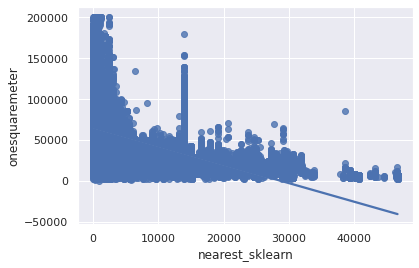

In [4]:
sns.regplot(data = linreg_dataset, x ="nearest_sklearn",y="onesquaremeter")

In [58]:
#2 - Calculer beta0 et beta1

price_mean = linreg_dataset.onesquaremeter.mean()
distance_mean = linreg_dataset.nearest_sklearn.mean()

dx_dy = (linreg_dataset["nearest_sklearn"] - distance_mean) * (linreg_dataset["onesquaremeter"] - price_mean)
dx_squared = (linreg_dataset["nearest_sklearn"] - distance_mean)**2

beta0 = dx_dy.sum() / dx_squared.sum()


beta1 = price_mean - beta0 * distance_mean

print("Intercept: ",beta0,"\nAbcisse:",beta1)



Intercept:  -2.2682378776320253 
Abcisse: 65592.4211467476


In [69]:
#3- Calculer r,t, p-value et résidus

from scipy.stats import t


r_squared = (linreg_dataset.corr()['nearest_sklearn']['onesquaremeter'])**2
r_squared

residuals = linreg_dataset["nearest_sklearn"].apply(lambda g : beta0*g + beta1) - linreg_dataset["onesquaremeter"]
length = len(residuals)

std_error = residuals.std() / linreg_dataset["nearest_sklearn"].std() / (length-2)**0.5
t_value = beta0/std_error

p_value = t.sf(np.abs(t_value), length-1)


print("Coefficient r_carre=",r_squared,"\nStatistique t: ",t_value,"\nErreur standard: ",std_error,f"\nP-value: %6.3f"%p_value)


Coefficient r_carre= 0.2558841934132977 
Statistique t:  -393.66904896985267 
Erreur standard:  0.005761788699333911 
P-value:  0.000


<AxesSubplot:ylabel='Count'>

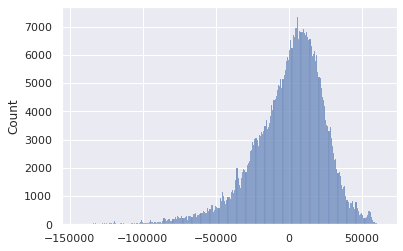

In [71]:
sns.histplot(residuals)

On constate que cet histogramme a l'allure d'une distribution normale centrée en 0